# Hamiltonian Monte Carlo for linear regression

The derivations presented for HMC are based on: Radford M. Neal (2012). MCMC using Hamiltonian dynamics. arXiv:1206.1901v1 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Derivation for linear regression

<b>Likelihood and priors</b>

In linear regression, we are given a dataset $\mathcal{D}=\{(\mathbf{x}_i, y_i)\}_{i=1}^N$ and the objective is to fit a model of form $p(y|\mathbf{x}, \mathbf{w}, b, \sigma^2) = \mathcal{N}(y | \mathbf{w}^T\mathbf{x} + b, \sigma^2)$ to this data.  

To simplify the notation a bit, let us define the design matrix
$$
X = \begin{pmatrix}
x_1^1 & x_1^2 & ... & x_1^d & 1\\
x_2^1 & x_2^2 & ... & x_2^d & 1\\
. & .\\
. & .\\
. & .\\
x_N^1 & x_N^2 & ... & x_N^d & 1\\
\end{pmatrix}$$  

Let us also collect all parameters for the mean and the outputs into vectors $\boldsymbol{\theta} = [w_1, w_2, ..., w_d, b]^T$ and $\mathbf{y} = [y_1, y_2, ..., y_N]^T$  

Then
  
$$\mathbf{X}\boldsymbol{\theta} = \begin{pmatrix}
\mathbf{w}^T\mathbf{x}_1 + b\\
\mathbf{w}^T\mathbf{x}_2 + b\\
.\\
.\\
.\\
\mathbf{w}^T\mathbf{x}_N + b
\end{pmatrix}$$

We next define noninformative priors for all model parameters. For the parameters $\boldsymbol{\theta}$, the support is $\mathbb{R}^{d+1}$. A natural choice is therefore $p(\boldsymbol{\theta}) = \mathcal{N(\mathbf{0}, \sigma_0^2\mathbf{I})}$, where the variance $\sigma_0^2$ is large.

We place the prior of the noise over the precision $\tau = \sigma^{-2}$. The support is $[0, \infty)$, so a natural choice is $p(\tau) = \Gamma(\alpha_0, \beta_0)$

<b>Posterior</b>

The posterior distribution is $$p(\boldsymbol{\theta}, \tau | \mathcal{D}) = \frac{p(\boldsymbol{\theta}, \tau)p(\mathbf{y} | \mathbf{X}, \boldsymbol{\theta}, \tau)}{Z} \propto \exp(-\frac{1}{2\sigma_0^2}\boldsymbol{\theta}^T \boldsymbol{\theta}) \tau^{\alpha_0 - 1} \exp(-\beta_0\tau) \prod_{i=1}^N \sqrt{\frac{\tau}{2\pi}}\exp(-\frac{\tau}{2}(y_i - (\mathbf{w}^T\mathbf{x}_i + b))^2)$$

In the likelihood, we can take the exponentiation outside the product and then combine terms which gives

$$p(\boldsymbol{\theta}, \tau | \mathcal{D}) \propto \tau^{\alpha_0 + N/2 - 1} \exp(\sum_{i=1}^N (-\frac{\tau}{2}(y_i - (\mathbf{w}^T\mathbf{x}_i + b))^2) - \frac{1}{2\sigma_0^2}\boldsymbol{\theta}^T \boldsymbol{\theta} - \beta_0\tau) = \tau^{\alpha_0 + N/2 - 1} \exp(-\frac{\tau}{2}(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\theta}) - \frac{1}{2\sigma_0^2}\boldsymbol{\theta}^T \boldsymbol{\theta} - \beta_0\tau)$$

<b>Conditional distributions</b>

The posterior above does not resemble any known distribution, so we will use MCMC to sample from the posterior. We will use a Gibbs sampling scheme that alternates between sampling from the conditional distributions $p(\boldsymbol{\theta}|\tau, \mathcal{D})$ and $p(\tau|\boldsymbol{\theta}, \mathcal{D})$. For sampling the weights and the bias from $p(\boldsymbol{\theta}|\tau, \mathcal{D})$, we will use HMC. However, HMC is not optimal for sampling the precision from $p(\tau|\boldsymbol{\theta}, \mathcal{D})$, since the support is constrained to be positive. The prior we have chosen for $\tau$ is conjugate to the gaussian likelihood, so we conveniently get

$$p(\tau|\boldsymbol{\theta}, \mathcal{D}) \propto \tau^{\alpha_0 + N/2 - 1}\exp(-\tau(\frac{1}{2}(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\theta}) + \beta_0)) $$

We can now recognize that this has the form of a gamma distribution. The parameters are given by

$$\alpha - 1 = \alpha_0 + N/2 - 1 \Rightarrow \alpha = \alpha_0 + N/2$$
$$\beta = \beta_0 + \frac{1}{2}(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})$$

We can conclude that $p(\tau|\boldsymbol{\theta}, \mathcal{D}) = \Gamma(\alpha, \beta)$. <i>Note:</i> The reason why we obtain the exact distribution despite dropping constants is that we only need to match the factors that depend on $\tau$, since then the normalization constants will also match as both distributions must integrate to 1.

Next, we are going to derive the unnormalized distribution for $\boldsymbol{\theta}$, which we will then sample from with HMC.

$$p(\boldsymbol{\theta} | \tau, \mathcal{D}) \propto \exp(-\frac{1}{2}(\tau(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\theta}) + \frac{1}{\sigma_0^2}\boldsymbol{\theta}^T \boldsymbol{\theta}))$$

<b>Energy functions and gradients</b>

In HMC, the energy (or Hamiltonian) $H(\mathbf{s})$of a state $\mathbf{s}$ is related to its probability by the canonical ensemble

$$p(\mathbf{s}) = \frac{1}{Z}\exp(-H(\mathbf{s})/T)$$

where $T$ is a temperature parameter. $T=1$ corresponds to our distribution of interest. Larger values of $T$ correspond to a more coarse-grained view of the distribution, which can make it easier for the chain to jump between modes. Let us assume from now on that $T=1$.

The state $\mathbf{s}$ consists of "position" variables $\mathbf{q}$ and "momentum" variables $\mathbf{p}$, i.e. $\mathbf{s} = (\mathbf{q}, \mathbf{p})$. The position variables are our original model parameters (so let us denote $\mathbf{s} = (\boldsymbol{\theta}, \mathbf{p})$ from now on), and the momentum variables are artificially introduced auxiliary variables.

The energy decomposes as a sum of potential energy $U$ and kinetic energy $K$. The potential energy is a function of position $\mathbf{q}$; it is directly related to our distribution of interest through the canonical ensemble.

$$p(\boldsymbol{\theta} | \tau, \mathcal{D}) = \frac{1}{Z}\exp(-\frac{1}{2}(\tau(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\theta}) + \frac{1}{\sigma_0^2}\boldsymbol{\theta}^T \boldsymbol{\theta})) = \frac{1}{Z}\exp(-U(\boldsymbol{\theta})) \Rightarrow U(\boldsymbol{\theta}) = \frac{1}{2}(\tau(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^T(\mathbf{y} - \mathbf{X}\boldsymbol{\theta}) + \frac{1}{\sigma_0^2}\boldsymbol{\theta}^T \boldsymbol{\theta})$$

For HMC we need the gradient of the Hamiltonian with respect to $\boldsymbol{\theta}$. For a more complicated distribution, this could be done with automatic differentiation. In our case it is quite simple, so we do it analytically.

$$\nabla_{\boldsymbol{\theta}}H(\boldsymbol{\theta}) = \nabla_{\boldsymbol{\theta}}U(\boldsymbol{\theta} | \tau, \mathcal{D}) = \frac{1}{2}(\tau\nabla_{\boldsymbol{\theta}}(\mathbf{y}^T\mathbf{y} - 2\boldsymbol{\theta}^T\mathbf{X}^T\mathbf{y} + \boldsymbol{\theta}^T\mathbf{X}^T\mathbf{X}\boldsymbol{\theta}) + \frac{1}{\sigma_0^2}\nabla_{\boldsymbol{\theta}}(\boldsymbol{\theta}^T\boldsymbol{\theta})) = \frac{1}{2}(\tau(-2\mathbf{X}^T\mathbf{y} + 2\mathbf{X}^T\mathbf{X}\boldsymbol{\theta}) + \frac{1}{\sigma_0^2}(2\boldsymbol{\theta})) = \tau(\mathbf{X}^T\mathbf{X}\boldsymbol{\theta} - \mathbf{X}^T\mathbf{y}) + \frac{1}{\sigma_0^2}\boldsymbol{\theta}$$

For the kinetic energy, we have 

$$K(\mathbf{p}) = \sum_{i=1}^d\frac{p_i^2}{2m_i}$$

which follows from the familiar formula $K = \frac{1}{2}mv^2$. The masses $m_i$ are a hyperparameters of the algorithm. The gradient of the Hamiltonian with respect to the momemtum is then

$$\nabla_{\mathbf{p}}H(\mathbf{p}) = \nabla_{\mathbf{p}}K(\mathbf{p}) = [\frac{p_1}{m_1}, \frac{p_2}{m_2}, ..., \frac{p_d}{m_d}]$$

<b>Hamiltonian mechanics</b>

In HMC, the proposal is computed by simulating Hamiltonian mechanics. This is done by solving the following ODE:

$$\frac{d\mathbf{q}}{dt} = \nabla_{\mathbf{p}}H(\mathbf{p}) = [\frac{p_1}{m_1}, \frac{p_2}{m_2}, ..., \frac{p_d}{m_d}]$$

$$\frac{d\mathbf{p}}{dt} = -\nabla_{\mathbf{q}}H(\mathbf{q}) = -\tau(\mathbf{X}^T\mathbf{X}\boldsymbol{\theta} - \mathbf{X}^T\mathbf{y}) - \frac{1}{\sigma_0^2}\boldsymbol{\theta}$$

In practise, we do this with a numerical ODE solver. The proposal is then accepted or rejected according to the Metropolis-Hastings acceptance rule.

## HMC implementation

In [60]:
class ODESolver:
    
    def __init__(self, grad_U, epsilon, L, m):
        self.grad_U = grad_U
        self.epsilon = epsilon
        self.L = L
        self.m = m
        
    def dq(self, p):
        return p / self.m
    
    def euler(self, q, p, tau):
        for i in range(self.L):
            p_new = p - epsilon * self.grad_U(q, tau)
            q = q + self.epsilon * self.dq(p)
            p = p_new
        return q, p
    
    def modified_euler(self, q, p, tau):
        for i in range(self.L):
            p = p - self.epsilon * self.grad_U(q, tau)
            q = q + self.epsilon * self.dq(p)
        return q, p
    
    def leapfrog(self, q, p, tau):
        p = p - self.epsilon * self.grad_U(q, tau) / 2
        for i in range(self.L):
            q = q + self.epsilon * self.dq(p)
            if i != self.L - 1:
                p = p - self.epsilon * self.grad_U(q, tau)
        p = p - self.epsilon * self.grad_U(q, tau) / 2
        p = -p
        return q, p

In [150]:
class HMC:
    
    def __init__(self, U, grad_U, p_tau, m, d, solver):
        self.U = U
        self.grad_U = grad_U
        self.p_tau = p_tau
        self.m = m
        self.d = d
        self.solver = solver
        self.samples = None
    
    def step(self, q, tau):
        p = np.random.multivariate_normal(np.zeros(self.d + 1), np.diag([1] * (self.d + 1)))
        q_proposed, p_proposed = self.solver.leapfrog(q, p, tau)
        U = self.U(q, tau)
        K = ((p ** 2) / (2 * self.m)).sum()
        U_proposed = self.U(q_proposed, tau)
        K_proposed = ((p_proposed ** 2) / (2 * self.m)).sum()
        u = np.random.uniform()
        if u < np.exp(U - U_proposed + K - K_proposed):
            return q_proposed, 1
        else:
            return q, 0
    
    def run(self, theta, tau, num_samples=1000, burn_in=100):
        
        N = num_samples - burn_in
        self.samples = np.zeros((N, self.d + 2))
        acceptances = []
        
        for i in range(num_samples):
            tau = self.p_tau(tau, theta)
            theta, acceptance = self.step(theta, tau)
            
            if i >= burn_in:
                j = i - burn_in
                self.samples[j, 0] = 1 / np.sqrt(tau)
                self.samples[j, 1:] = theta
                acceptances.append(acceptance)
        
        return self.samples, acceptances
    
    def plot(self, true_params):
        
        num_params = self.d + 2
        plt.figure(figsize=(15, 5 * num_params))
        param_names = ["sigma"]
        
        for i in range(num_params - 2):
            param_names.append("weight " + str(i+1))
        param_names.append("intercept")
        
        for i in range(num_params):
            true_val = true_params[i]
            samples = self.samples[:, i]
            plt.subplot(num_params,2,i*2+1)
            y, _, _ = plt.hist(samples, bins=100, label="samples")
            max_y = int(np.max(y))
            plt.plot([true_val] * max_y, range(max_y), c="r", label="true value")
            plt.title("Histogram for {}".format(param_names[i]))
            plt.legend()
            plt.subplot(num_params,2,i*2+2)
            plt.plot(samples, label="chain")
            plt.plot([0, samples.size], [true_val, true_val], c="r", label="true value")
            plt.title("Trace plot for {}".format(param_names[i]))
            plt.legend()
            
        plt.show()

    def evaluate(self, test_simulator):
        
        "Computes MSE between test data and the predictions of the model"
        
        test_covariates = test_simulator.X
        mean_weights = self.samples.mean(axis=0)[1:]
        predictions = test_covariates @ mean_weights
        mse = ((predictions - test_simulator.y) ** 2).mean()
        return mse

In [151]:
# Helper function for constructing potential energy function
def create_U(X, y, sigma_0):
    
    def U(theta, tau):
        z = y - X @ theta
        return 0.5 * (tau * z.T @ z + theta.T @ theta / (sigma_0 ** 2))
    
    return U

# Helper function for constructing gradient of potential energy function
def create_grad_U(X, y, sigma_0):
    
    def grad_U(theta, tau):
        return tau * (X.T @ X @ theta - X.T @ y) + (theta / (sigma_0 ** 2))
    
    return grad_U


# Helper function for constructing conditional distribution for tau
def create_p_tau(X, y, alpha_0, beta_0, N):
    alpha = alpha_0 + N / 2
    
    def p_tau(tau, theta):
        z = y - X @ theta
        beta = beta_0 + 0.5 * z.T @ z
        return np.random.gamma(alpha, 1 / beta)
    
    return p_tau

## Simulating data

In [136]:
class Simulator:
    
    def __init__(self, w, b, sigma, N, design_range=(-10,10)):
        self.w = w
        self.b = b
        self.theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
        self.sigma = sigma
        self.N = N
        self.design_range = design_range
        self.X = None
        self.y = None
        self.y_mean = None
        
    def run(self):
        designs = np.random.uniform(self.design_range[0], self.design_range[1], size=(self.N, self.w.size))
        self.X = np.concatenate([designs, np.ones((self.N, 1))], axis=1)
        self.y_mean = (self.X @ self.theta).squeeze()
        self.y = np.random.multivariate_normal(mean=self.y_mean, cov=np.diag([self.sigma**2] * self.N))
    
    def plot(self):
        x = self.X[:, 0]
        plt.scatter(x, self.y, label="data")
        x_dense = np.linspace(self.design_range[0], self.design_range[1], 100)
        y_dense = x_dense * self.w[0] + self.b
        plt.plot(x_dense, y_dense, label="y mean")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Simulated data, N="+str(self.N))
        plt.show()

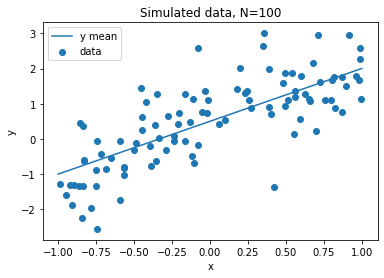

In [119]:
# True weight(s)
w = np.array([1.5, -1.0, 0.7])

# Input dimensionality
d = w.size

# True intercept
b = 0.5

# True standard deviation
sigma = 0.5

# Number of data points
N = 100

# Defines range of inputs x
design_range = (-1.0, 1.0)

# Simulate
simulator = Simulator(w, b, sigma, N, design_range)
simulator.run()
simulator.plot()

## Running the chain

In [120]:
# Define priors
sigma_0 = 1000
alpha_0 = 0.001
beta_0 = 0.001

# Create helper functions
U = create_U(X=simulator.X, y=simulator.y, sigma_0=sigma_0)
grad_U = create_grad_U(X=simulator.X, y=simulator.y, sigma_0=sigma_0)
p_tau = create_p_tau(X=simulator.X, y=simulator.y, alpha_0=alpha_0, beta_0=beta_0, N=simulator.N)

# Define HMC parameters

# Step size
epsilon = 0.01

# Number of steps in the proposal
L = 20

# Mass parameter
m = 1.0

solver = ODESolver(grad_U, epsilon, L, m)

chain = HMC(U, grad_U, p_tau, m, d, solver)

# Initialize chain
theta = np.zeros(d+1)
tau = 1.0

# Run chain
samples, acceptances = chain.run(theta, tau, num_samples=10000)

In [121]:
theta_samples = samples[:, 1:]
sigma_samples = samples[:, 0]
print("Estimated theta: {}".format(np.mean(theta_samples, axis=0)))
print("True theta: {}".format(np.concatenate([w, np.expand_dims(b, 0)], axis=0)))
print("\nEstimated sigma: {}".format(sigma_samples.mean()))
print("True sigma: {}".format(sigma))
print("\nAcceptance rate: {}".format(np.mean(acceptances)))

Estimated theta: [ 1.57990585 -0.94028274  0.70914764  0.47367735]
True theta: [ 1.5 -1.   0.7  0.5]

Estimated sigma: 0.4688716829183135
True sigma: 0.5

Acceptance rate: 0.9961616161616161


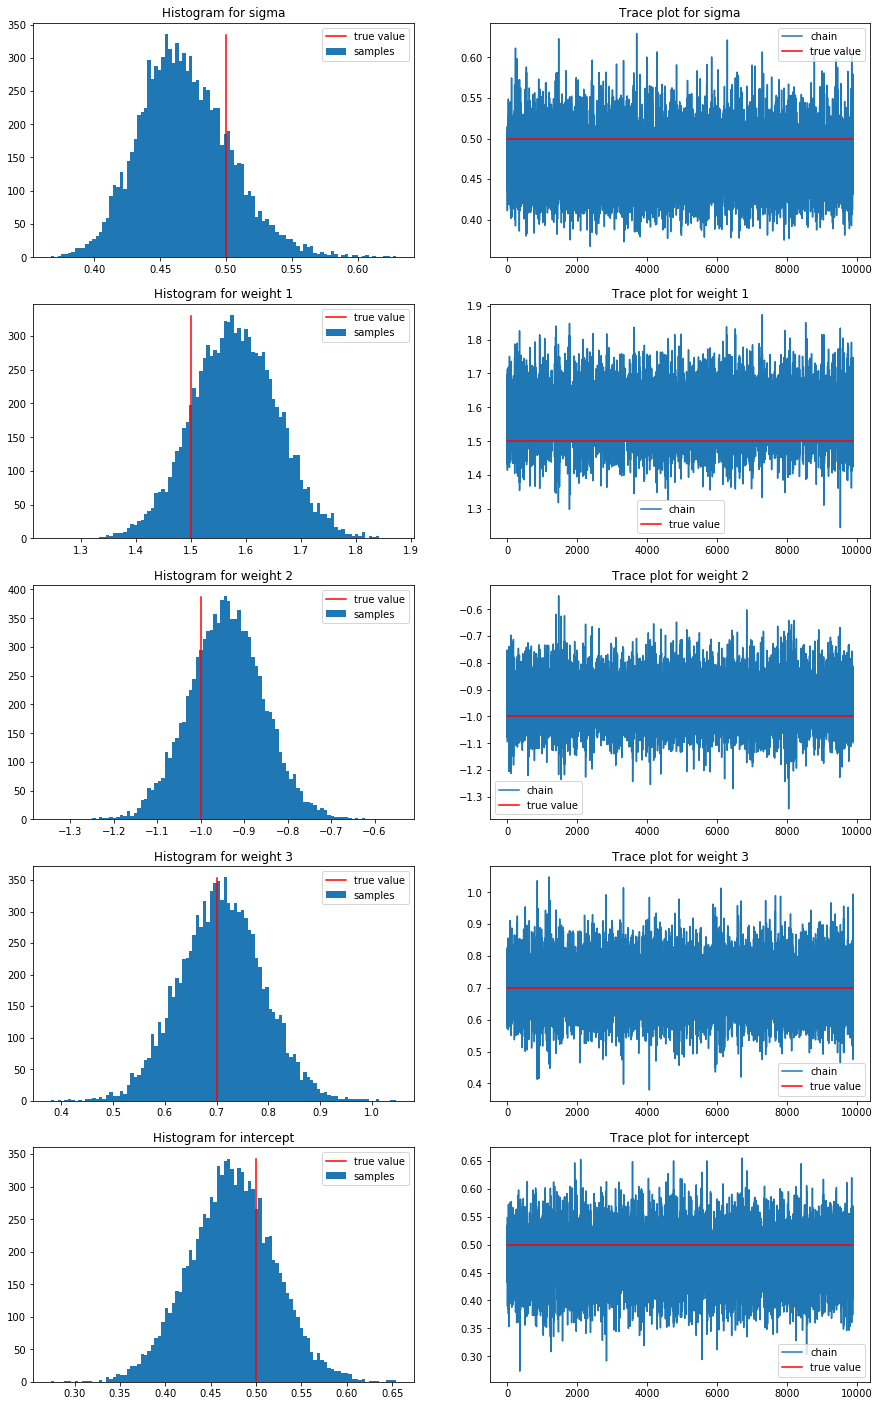

In [122]:
# Qualitative diagnostics
true_params = np.concatenate([[sigma], w, [b]], axis=0)
chain.plot(true_params)

## Diagnostics

### Potential scaling reduction factor (PSRF, also called R-hat)

In [123]:
def compute_psrf(samples):
    
    """
    param samples: 3 dimensional numpy array of shape (M, N, P)
    returns: R-hat values for each model parameter
    """
    M, N, P = samples.shape
    
    within_chain_means = samples.mean(axis=1)
    within_chain_vars = samples.var(axis=1)
    between_chain_means = samples.mean(axis=(0, 1))
    
    B = N * ((within_chain_means - between_chain_means) ** 2).sum(axis=(0)) / (M - 1)
    
    W = within_chain_vars.mean(axis=0)
    
    V = (N - 1) * W / N + (M + 1) * B / (M * N)
    
    psrf = np.sqrt(V / W)
    
    return psrf

In [125]:
# Number of chains
M = 5

# Number of samples per chain (excluding burnin)
N = 1000

# Number of samples discarded from start of the chain
burn_in = 500

# Total number of parameters in the model
P = d + 2

# Initialize samples array
samples = np.zeros((M, N, P))

# Run M chains
for m in range(M):

    # Initialize chain stochastically
    theta = np.zeros(d + 1) + np.random.normal(loc=0, scale=0.5, size=(d + 1))
    tau = 1.0 + np.random.normal(loc=0, scale=0.2)

    # Run chain
    chain_samples, acceptances = chain.run(theta, tau, num_samples=N+burn_in, burn_in=burn_in)
    
    # Store within chain samples
    samples[m, :, :] = chain_samples
    
psrf = compute_psrf(samples)

print("PSRF values: {}".format(psrf))

# Check that all model parameters have converged
convergence_threshold = 1.1
if (psrf < convergence_threshold).all():
    print("Convergence test passed.")

PSRF values: [1.00047616 0.99954597 0.99985737 0.99955125 0.99960621]
Convergence test passed.


### Effective sample size (ESS)

## Evaluation

In this section we evaluate fits using some test data.

### Univariate setting

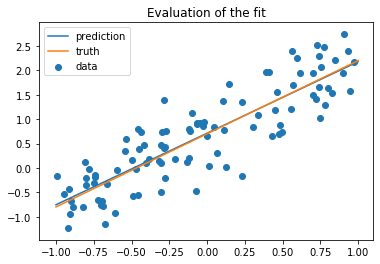

Test MSE: 0.2582406493246326


In [142]:
# Define true parameters
w = np.array([1.5]) # weight
b = 0.7 # intercept
sigma = 0.5 # noise standard deviation
N = 100  # number of data points
design_range = (-1.0, 1.0) # range of covariates
d = w.size # Number of covariates

simulator = Simulator(w, b, sigma, N, design_range)
simulator.run()

# Create helper functions based on data
U = create_U(X=simulator.X, y=simulator.y, sigma_0=sigma_0)
grad_U = create_grad_U(X=simulator.X, y=simulator.y, sigma_0=sigma_0)
p_tau = create_p_tau(X=simulator.X, y=simulator.y, alpha_0=alpha_0, beta_0=beta_0, N=simulator.N)

solver = ODESolver(grad_U, epsilon, L, m)
chain = HMC(U, grad_U, p_tau, m, d, solver)

# Initialize chain
theta = np.zeros(2)
tau = 1.0

# Run chain
samples, acceptances = chain.run(theta, tau, num_samples=10000)

posterior_mean = samples.mean(axis=0)

# Plot estimated model
x_axis = np.linspace(design_range[0], design_range[1], 100)
y_pred = x_axis * posterior_mean[1] + posterior_mean[2]
y_true = x_axis * w + b
plt.plot(x_axis, y_pred, label="prediction")
plt.plot(x_axis, y_true, label="truth")
plt.scatter(simulator.X[:, 0], simulator.y, label="data")
plt.legend()
plt.title("Evaluation of the fit")
plt.show()

# Simulate test data
test_simulator = Simulator(w, b, sigma, N, design_range)
test_simulator.run()
test_mse = chain.evaluate(test_simulator)
print("Test MSE: {}".format(test_mse))

### Multivariate setting

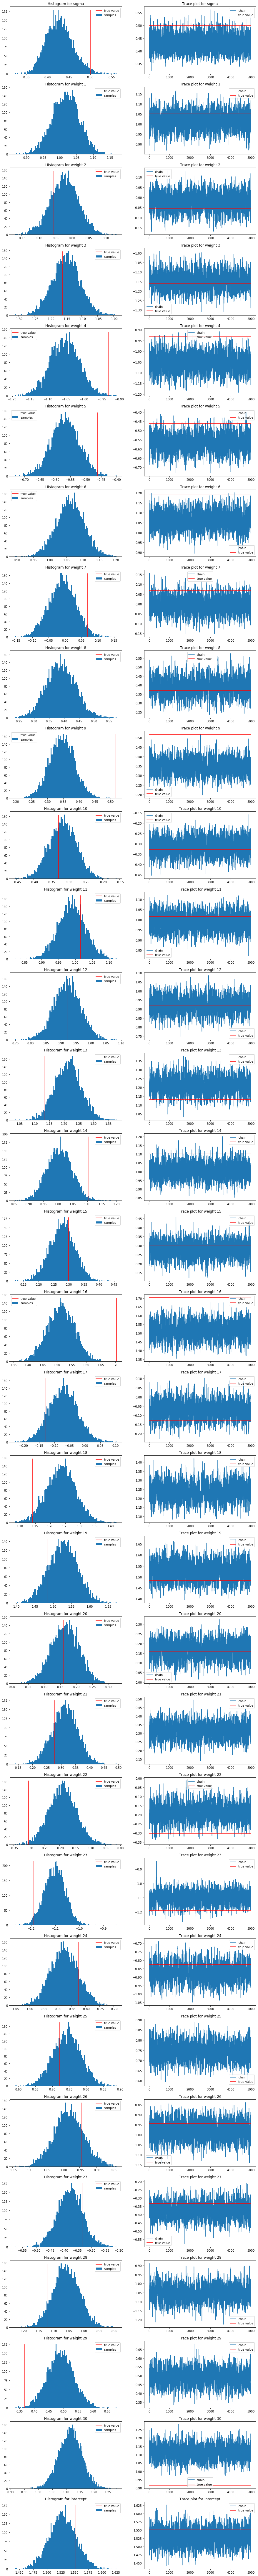

In [157]:
# Define true parameters
w = np.random.normal(0, 1, size=30) # sample weights
b = np.random.normal(0, 1) # sample intercept
sigma = 0.5 # noise standard deviation
N = 100  # number of data points
design_range = (-1.0, 1.0) # range of covariates
d = w.size # Number of covariates

simulator = Simulator(w, b, sigma, N, design_range)
simulator.run()

# Create helper functions based on data
U = create_U(X=simulator.X, y=simulator.y, sigma_0=sigma_0)
grad_U = create_grad_U(X=simulator.X, y=simulator.y, sigma_0=sigma_0)
p_tau = create_p_tau(X=simulator.X, y=simulator.y, alpha_0=alpha_0, beta_0=beta_0, N=simulator.N)

solver = ODESolver(grad_U, epsilon, L, m)
chain = HMC(U, grad_U, p_tau, m, d, solver)

# Initialize chain
theta = np.zeros(d+1)
tau = 1.0

# Run chain
samples, acceptances = chain.run(theta, tau, num_samples=10000, burn_in=5000)
true_params = np.concatenate([[sigma], w, [b]], axis=0)
chain.plot(true_params)

# Simulate test data
test_simulator = Simulator(w, b, sigma, N, design_range)
test_simulator.run()
test_mse = chain.evaluate(test_simulator)

In [158]:
print("Test MSE: {}".format(test_mse))

Test MSE: 0.27710489352341033
